# CellTypist Annotations - A tool for cell type annotation

## 1k PBMCs: All cells, all genes (excluding MALAT1)

In [ ]:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy
import sklearn
import anndata as ad 
from tqdm import tqdm as tqdm
import pysam
import scanpy as sc


base_dir = '/data/dagyeman/cellranger/bam_file_analysis'

### Naive Method 

In [12]:
import scanpy as sc
import celltypist
import os

dataset= "1k_PBMCs"  # Change to "10k_PBMCs" if needed

common_path = f"{base_dir}/{dataset}/ub_objects/adata_matrices"
# common_path = "/data/dagyeman/cellranger/bam_file_analysis/10k_PBMCs/ur_objects/adata_matrices"
filepath = common_path
output_path = os.path.join(common_path, "cell_annotations")

# Load the CellTypist model
model = celltypist.models.Model.load(model='Healthy_COVID19_PBMC.pkl')

# Ensure the output directory exists
os.makedirs(output_path, exist_ok=True)

# Dictionary to store annotated data
annotated_adata_dict = {}

# Process each UMI length
for i in range(1, 13):
    print(f"Processing UMI length: {i}")
    
    # Load the h5ad file for the current UMI length
    adata = sc.read_h5ad(filepath + f"/adata_{i}.h5ad")
    
    # Normalize counts per cell to 10,000
    sc.pp.normalize_total(adata, target_sum=1e4)
    
    # Apply log1p transformation
    sc.pp.log1p(adata)
    
    # Check matrix sample (optional)
    print(f"Sample of the matrix for UMI length {i}:")
    print(adata.X[:5, :5])
    print(f"Min: {adata.X.min()}, Max: {adata.X.max()}")
    
    # Annotate the cell types using the CellTypist model
    predictions = celltypist.annotate(adata, model=model, majority_voting=True)
    
    # Store annotated data
    annotated_adata = predictions.to_adata()
    annotated_adata_dict[i] = annotated_adata
    
    # Save annotated AnnData object
    annotated_output_path = os.path.join(output_path, f"annotated_adata_matrices/annotated_adata_{i}.h5ad")
    annotated_adata.write_h5ad(annotated_output_path)
    print(f"Annotated data saved to: {annotated_output_path}\n")

    # # Compute UMAP
    # sc.tl.umap(annotated_adata)

    # # Plot UMAP with majority voting labels
    # sc.pl.umap(
    #     annotated_adata, 
    #     color=['majority_voting'], 
    #     legend_loc='on data', 
    #     title=f"UMAP for UMI length {i}", 
    #     show=True  # Display instead of saving
    # )

Processing UMI length: 1


🔬 Input data has 1232 cells and 28226 genes
🔗 Matching reference genes in the model


Sample of the matrix for UMI length 1:
[[0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         1.75858657 0.         0.        ]
 [0.         0.         1.98234965 1.98234965 0.        ]
 [0.         0.         0.         0.         0.        ]]
Min: 0.0, Max: 7.339187983916088


🧬 3377 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!


Annotated data saved to: /data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/adata_matrices/cell_annotations/annotated_adata_matrices/annotated_adata_1.h5ad

Processing UMI length: 2


🔬 Input data has 1232 cells and 28226 genes
🔗 Matching reference genes in the model
🧬 3377 features used for prediction


Sample of the matrix for UMI length 2:
[[0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         1.88963086 0.         0.        ]
 [0.         0.         1.81785399 1.81785399 0.        ]
 [0.         0.         0.         0.         0.        ]]
Min: 0.0, Max: 7.856182134112137


⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!


Annotated data saved to: /data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/adata_matrices/cell_annotations/annotated_adata_matrices/annotated_adata_2.h5ad

Processing UMI length: 3


🔬 Input data has 1232 cells and 28226 genes
🔗 Matching reference genes in the model
🧬 3377 features used for prediction


Sample of the matrix for UMI length 3:
[[0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         1.77203496 0.         0.        ]
 [0.         0.         1.73704846 1.73704846 0.        ]
 [0.         0.         0.         0.         0.        ]]
Min: 0.0, Max: 8.091091211753842


⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!


Annotated data saved to: /data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/adata_matrices/cell_annotations/annotated_adata_matrices/annotated_adata_3.h5ad

Processing UMI length: 4


🔬 Input data has 1232 cells and 28226 genes
🔗 Matching reference genes in the model
🧬 3377 features used for prediction


Sample of the matrix for UMI length 4:
[[0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         1.71871507 0.         0.        ]
 [0.         0.         1.70244058 1.70244058 0.        ]
 [0.         0.         0.         0.         0.        ]]
Min: 0.0, Max: 8.384202821527866


⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!


Annotated data saved to: /data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/adata_matrices/cell_annotations/annotated_adata_matrices/annotated_adata_4.h5ad

Processing UMI length: 5


🔬 Input data has 1232 cells and 28226 genes
🔗 Matching reference genes in the model


Sample of the matrix for UMI length 5:
[[0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         1.69932847 0.         0.        ]
 [0.         0.         1.68845536 1.68845536 0.        ]
 [0.         0.         0.         0.         0.        ]]
Min: 0.0, Max: 8.53055826603421


🧬 3377 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!


Annotated data saved to: /data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/adata_matrices/cell_annotations/annotated_adata_matrices/annotated_adata_5.h5ad

Processing UMI length: 6


🔬 Input data has 1232 cells and 28226 genes
🔗 Matching reference genes in the model


Sample of the matrix for UMI length 6:
[[0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         1.69181976 0.         0.        ]
 [0.         0.         1.68451118 1.68451118 0.        ]
 [0.         0.         0.         0.         0.        ]]
Min: 0.0, Max: 8.58032586812956


🧬 3377 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!


Annotated data saved to: /data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/adata_matrices/cell_annotations/annotated_adata_matrices/annotated_adata_6.h5ad

Processing UMI length: 7


🔬 Input data has 1232 cells and 28226 genes
🔗 Matching reference genes in the model


Sample of the matrix for UMI length 7:
[[0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         1.68989523 0.         0.        ]
 [0.         0.         1.68254754 1.68254754 0.        ]
 [0.         0.         0.         0.         0.        ]]
Min: 0.0, Max: 8.591134130220313


🧬 3377 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!


Annotated data saved to: /data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/adata_matrices/cell_annotations/annotated_adata_matrices/annotated_adata_7.h5ad

Processing UMI length: 8


🔬 Input data has 1232 cells and 28226 genes
🔗 Matching reference genes in the model


Sample of the matrix for UMI length 8:
[[0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         1.68857523 0.         0.        ]
 [0.         0.         1.68219112 1.68219112 0.        ]
 [0.         0.         0.         0.         0.        ]]
Min: 0.0, Max: 8.587106699778493


🧬 3377 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!


Annotated data saved to: /data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/adata_matrices/cell_annotations/annotated_adata_matrices/annotated_adata_8.h5ad

Processing UMI length: 9


🔬 Input data has 1232 cells and 28226 genes
🔗 Matching reference genes in the model
🧬 3377 features used for prediction


Sample of the matrix for UMI length 9:
[[0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         1.68761682 0.         0.        ]
 [0.         0.         1.68112297 1.68112297 0.        ]
 [0.         0.         0.         0.         0.        ]]
Min: 0.0, Max: 8.585883686303646


⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!


Annotated data saved to: /data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/adata_matrices/cell_annotations/annotated_adata_matrices/annotated_adata_9.h5ad

Processing UMI length: 10


🔬 Input data has 1232 cells and 28226 genes
🔗 Matching reference genes in the model


Sample of the matrix for UMI length 10:
[[0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         1.68689889 0.         0.        ]
 [0.         0.         1.68005647 1.68005647 0.        ]
 [0.         0.         0.         0.         0.        ]]
Min: 0.0, Max: 8.58466216732117


🧬 3377 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!


Annotated data saved to: /data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/adata_matrices/cell_annotations/annotated_adata_matrices/annotated_adata_10.h5ad

Processing UMI length: 11


🔬 Input data has 1232 cells and 28226 genes
🔗 Matching reference genes in the model


Sample of the matrix for UMI length 11:
[[0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         1.6861817  0.         0.        ]
 [0.         0.         1.67952385 1.67952385 0.        ]
 [0.         0.         0.         0.         0.        ]]
Min: 0.0, Max: 8.58466216732117


🧬 3377 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!


Annotated data saved to: /data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/adata_matrices/cell_annotations/annotated_adata_matrices/annotated_adata_11.h5ad

Processing UMI length: 12


🔬 Input data has 1232 cells and 28226 genes
🔗 Matching reference genes in the model


Sample of the matrix for UMI length 12:
[[0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         1.68582339 0.         0.        ]
 [0.         0.         1.6793464  1.6793464  0.        ]
 [0.         0.         0.         0.         0.        ]]
Min: 0.0, Max: 8.58466216732117


🧬 3377 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!


Annotated data saved to: /data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/adata_matrices/cell_annotations/annotated_adata_matrices/annotated_adata_12.h5ad



### Method of Moments Estimator

In [13]:
import scanpy as sc
import celltypist
import os

dataset = "1k_PBMCs"  # Change to "10k_PBMCs" if needed
common_path = f"{base_dir}/{dataset}/ub_objects/col_aware_nunif_matrices" # 1k

# Define file paths
filepath = common_path
output_path = os.path.join(common_path, "cell_annotations")

# Load the CellTypist model
model = celltypist.models.Model.load(model='Healthy_COVID19_PBMC.pkl')

# Ensure the output directory exists
os.makedirs(output_path, exist_ok=True)

# Dictionary to store annotated data
annotated_adata_dict = {}

# Process each UMI length
for i in range(1, 13):
    print(f"Processing UMI length: {i}")
    
    # Load the h5ad file for the current UMI length
    adata = sc.read_h5ad(filepath + f"/adata_{i}.h5ad")
    
    # Normalize counts per cell to 10,000
    sc.pp.normalize_total(adata, target_sum=1e4)
    
    # Apply log1p transformation
    sc.pp.log1p(adata)
    
    # Check matrix sample (optional)
    print(f"Sample of the matrix for UMI length {i}:")
    print(adata.X[:5, :5])
    print(f"Min: {adata.X.min()}, Max: {adata.X.max()}")
    
    # Annotate the cell types using the CellTypist model
    predictions = celltypist.annotate(adata, model=model, majority_voting=True)
    
    # Store annotated data
    annotated_adata = predictions.to_adata()
    annotated_adata_dict[i] = annotated_adata
    
    # Save annotated AnnData object
    annotated_output_path = os.path.join(output_path, f"annotated_inv_matrices/annotated_adata_{i}.h5ad")
    annotated_adata.write_h5ad(annotated_output_path)
    print(f"Annotated data saved to: {annotated_output_path}\n")

    # Compute UMAP
    # sc.tl.umap(annotated_adata)

    # # Plot UMAP with majority voting labels
    # sc.pl.umap(
    #     annotated_adata, 
    #     color=['majority_voting'], 
    #     legend_loc='on data', 
    #     title=f"UMAP for UMI length {i}(inverted)", 
    #     show=True  # Display instead of saving
    # )


Processing UMI length: 1


🔬 Input data has 1232 cells and 28226 genes
🔗 Matching reference genes in the model


Sample of the matrix for UMI length 1:
[[0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         1.71275466 0.         0.        ]
 [0.         0.         1.96977533 1.96977533 0.        ]
 [0.         0.         0.         0.         0.        ]]
Min: 0.0, Max: 7.646527808042398


🧬 3377 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!


Annotated data saved to: /data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/col_aware_nunif_matrices/cell_annotations/annotated_inv_matrices/annotated_adata_1.h5ad

Processing UMI length: 2


🔬 Input data has 1232 cells and 28226 genes
🔗 Matching reference genes in the model


Sample of the matrix for UMI length 2:
[[0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         1.76168012 0.         0.        ]
 [0.         0.         1.73146049 1.73146049 0.        ]
 [0.         0.         0.         0.         0.        ]]
Min: 0.0, Max: 8.040322759768344


🧬 3377 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!


Annotated data saved to: /data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/col_aware_nunif_matrices/cell_annotations/annotated_inv_matrices/annotated_adata_2.h5ad

Processing UMI length: 3


🔬 Input data has 1232 cells and 28226 genes
🔗 Matching reference genes in the model


Sample of the matrix for UMI length 3:
[[0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         1.69470588 0.         0.        ]
 [0.         0.         1.7001125  1.7001125  0.        ]
 [0.         0.         0.         0.         0.        ]]
Min: 0.0, Max: 8.42178787770164


🧬 3377 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!


Annotated data saved to: /data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/col_aware_nunif_matrices/cell_annotations/annotated_inv_matrices/annotated_adata_3.h5ad

Processing UMI length: 4


🔬 Input data has 1232 cells and 28226 genes
🔗 Matching reference genes in the model


Sample of the matrix for UMI length 4:
[[0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         1.69180773 0.         0.        ]
 [0.         0.         1.68909126 1.68909126 0.        ]
 [0.         0.         0.         0.         0.        ]]
Min: 0.0, Max: 8.588980249672082


🧬 3377 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!


Annotated data saved to: /data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/col_aware_nunif_matrices/cell_annotations/annotated_inv_matrices/annotated_adata_4.h5ad

Processing UMI length: 5


🔬 Input data has 1232 cells and 28226 genes
🔗 Matching reference genes in the model


Sample of the matrix for UMI length 5:
[[0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         1.69168243 0.         0.        ]
 [0.         0.         1.68430722 1.68430722 0.        ]
 [0.         0.         0.         0.         0.        ]]
Min: 0.0, Max: 8.591336158572577


🧬 3377 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!


Annotated data saved to: /data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/col_aware_nunif_matrices/cell_annotations/annotated_inv_matrices/annotated_adata_5.h5ad

Processing UMI length: 6


🔬 Input data has 1232 cells and 28226 genes
🔗 Matching reference genes in the model


Sample of the matrix for UMI length 6:
[[0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         1.68969506 0.         0.        ]
 [0.         0.         1.68338701 1.68338701 0.        ]
 [0.         0.         0.         0.         0.        ]]
Min: 0.0, Max: 8.596974237188222


🧬 3377 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!


Annotated data saved to: /data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/col_aware_nunif_matrices/cell_annotations/annotated_inv_matrices/annotated_adata_6.h5ad

Processing UMI length: 7


🔬 Input data has 1232 cells and 28226 genes
🔗 Matching reference genes in the model


Sample of the matrix for UMI length 7:
[[0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         1.6893443  0.         0.        ]
 [0.         0.         1.68225802 1.68225802 0.        ]
 [0.         0.         0.         0.         0.        ]]
Min: 0.0, Max: 8.595440919863025


🧬 3377 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!


Annotated data saved to: /data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/col_aware_nunif_matrices/cell_annotations/annotated_inv_matrices/annotated_adata_7.h5ad

Processing UMI length: 8


🔬 Input data has 1232 cells and 28226 genes
🔗 Matching reference genes in the model


Sample of the matrix for UMI length 8:
[[0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         1.688433   0.         0.        ]
 [0.         0.         1.68211692 1.68211692 0.        ]
 [0.         0.         0.         0.         0.        ]]
Min: 0.0, Max: 8.588203100134532


🧬 3377 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!


Annotated data saved to: /data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/col_aware_nunif_matrices/cell_annotations/annotated_inv_matrices/annotated_adata_8.h5ad

Processing UMI length: 9


🔬 Input data has 1232 cells and 28226 genes
🔗 Matching reference genes in the model


Sample of the matrix for UMI length 9:
[[0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         1.6875795  0.         0.        ]
 [0.         0.         1.68110373 1.68110373 0.        ]
 [0.         0.         0.         0.         0.        ]]
Min: 0.0, Max: 8.58616435172065


🧬 3377 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!


Annotated data saved to: /data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/col_aware_nunif_matrices/cell_annotations/annotated_inv_matrices/annotated_adata_9.h5ad

Processing UMI length: 10


🔬 Input data has 1232 cells and 28226 genes
🔗 Matching reference genes in the model


Sample of the matrix for UMI length 10:
[[0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         1.6868894  0.         0.        ]
 [0.         0.         1.68005049 1.68005049 0.        ]
 [0.         0.         0.         0.         0.        ]]
Min: 0.0, Max: 8.58473409042606


🧬 3377 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!


Annotated data saved to: /data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/col_aware_nunif_matrices/cell_annotations/annotated_inv_matrices/annotated_adata_10.h5ad

Processing UMI length: 11


🔬 Input data has 1232 cells and 28226 genes
🔗 Matching reference genes in the model
🧬 3377 features used for prediction


Sample of the matrix for UMI length 11:
[[0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         1.68617588 0.         0.        ]
 [0.         0.         1.67954046 1.67954046 0.        ]
 [0.         0.         0.         0.         0.        ]]
Min: 0.0, Max: 8.584680703938506


⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!


Annotated data saved to: /data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/col_aware_nunif_matrices/cell_annotations/annotated_inv_matrices/annotated_adata_11.h5ad

Processing UMI length: 12


🔬 Input data has 1232 cells and 28226 genes
🔗 Matching reference genes in the model


Sample of the matrix for UMI length 12:
[[0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         1.68578063 0.         0.        ]
 [0.         0.         1.6794711  1.6794711  0.        ]
 [0.         0.         0.         0.         0.        ]]
Min: 0.0, Max: 8.584670875716961


🧬 3377 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!


Annotated data saved to: /data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/col_aware_nunif_matrices/cell_annotations/annotated_inv_matrices/annotated_adata_12.h5ad



### Celltypist Error Plot

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0.34983766 0.23538961 0.12662338 0.08928571 0.09253247 0.07142857
 0.03896104 0.03409091 0.04220779 0.07873377 0.03896104 0.        ]
[0.32548701 0.08603896 0.04464286 0.06574675 0.06980519 0.05844156
 0.07467532 0.0762987  0.05113636 0.07873377 0.03327922 0.00243506]
0.9107142857142857


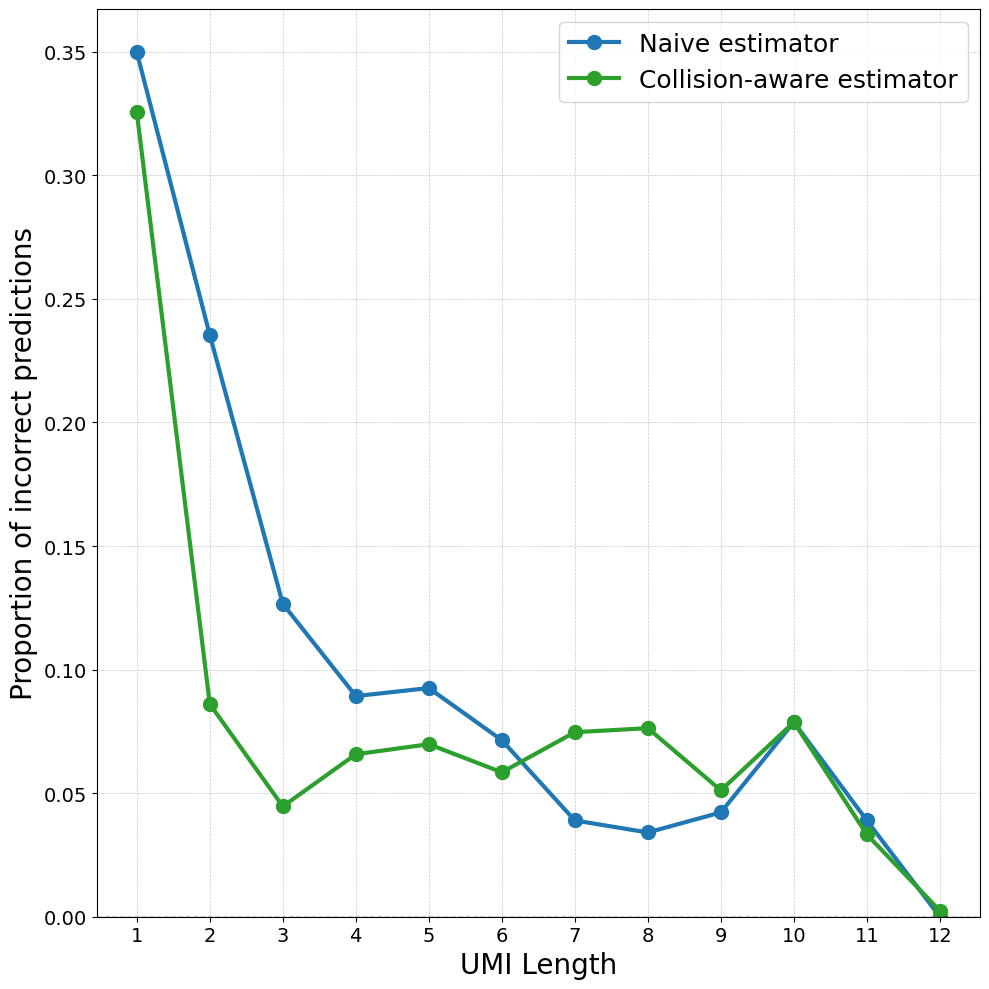

In [14]:
import os
import scanpy as sc
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
dataset = "1k_PBMCs"  # Change to "10k_PBMCs" if needed
# Paths
regular_path = f"{base_dir}/{dataset}/ub_objects/adata_matrices/cell_annotations/annotated_adata_matrices"
inverted_path = f"{base_dir}/{dataset}/ub_objects/col_aware_nunif_matrices/cell_annotations/annotated_inv_matrices"

# regular_path = "/data/dagyeman/cellranger/bam_file_analysis/10k_PBMCs/ur_objects/adata_matrices/cell_annotations/annotated_adata_matrices"
# inverted_path = "/data/dagyeman/cellranger/bam_file_analysis/10k_PBMCs/ur_objects/inverted2_adata_matrices/cell_annotations/annotated_inv_matrices"

# 1) Load regular annotated adata matrices into a dict
annotated_ads_reg = {
    i: sc.read_h5ad(f"{regular_path}/annotated_adata_{i}.h5ad")
    for i in range(1, 13)
}

# 2) Use UMI 12 as ground truth
ground_truth_adata = annotated_ads_reg[12]
common_cells = sorted(ground_truth_adata.obs_names)
ground_truth = ground_truth_adata.obs.loc[common_cells, 'majority_voting'].astype(str).values
gt_labels = ground_truth_adata.obs['majority_voting'].astype(str).to_dict()

# 4) Compute error vectors
error_vector_reg = np.zeros(12)
error_vector_inv = np.zeros(12)
print(error_vector_reg)
print(error_vector_inv)

for i in range(1, 13):
    # Regular predictions aligned to UMI-12 cells
    ad_reg = annotated_ads_reg[i]
    present = [c for c in common_cells if c in ad_reg.obs_names]
    preds_reg = ad_reg.obs.loc[present, 'majority_voting'].astype(str).values
    true_aligned = np.array([gt_labels[c] for c in present], dtype=str)
    error_vector_reg[i - 1] = np.mean(preds_reg != true_aligned)

    # Inverted predictions aligned to UMI-12 cells
    ad_inv = sc.read_h5ad(f"{inverted_path}/annotated_adata_{i}.h5ad")
    present_inv = [c for c in common_cells if c in ad_inv.obs_names]
    preds_inv = ad_inv.obs.loc[present_inv, 'majority_voting'].astype(str).values
    true_aligned_inv = np.array([gt_labels[c] for c in present_inv], dtype=str)
    error_vector_inv[i - 1] = np.mean(preds_inv != true_aligned_inv)

print(error_vector_reg)
print(error_vector_inv)
print(1 - error_vector_reg[3])

# 5) Plot both error curves
plt.figure(figsize=(10, 10))

# Blue for Naive (Regular)
plt.plot(
    range(1, 13), error_vector_reg, marker='o', linestyle='-',
    label='Naive estimator', markersize=10, linewidth=3, color='#1f77b4'
)

# Green for Collision-aware (Inverted)
plt.plot(
    range(1, 13), error_vector_inv, marker='o', linestyle='-',
    label='Collision-aware estimator', markersize=10, linewidth=3, color='#2ca02c'
)

plt.xlabel('UMI Length', fontsize=20)
plt.ylabel('Proportion of incorrect predictions', fontsize=20)
plt.ylim(bottom=0)
plt.xticks(range(1, 13), fontsize=14)
plt.yticks(fontsize=14)
plt.axhline(y=0, color='k', linestyle='--', linewidth=1)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
# plt.title('Error in Cell Type Predictions (All Genes, No MALAT1)', fontsize=24)
plt.legend(fontsize=18)
plt.tight_layout()
out_file = f"{base_dir}/figures/{dataset}/{dataset}_cell_typist_error.pdf"
# os.makedirs(os.path.dirname(out_file), exist_ok=True)
plt.savefig(out_file)
plt.show()

## 10k PBMCs: All cells, all genes (excluding MALAT1)

### Naive Method 

In [15]:
import scanpy as sc
import celltypist
import os

dataset= "10k_PBMCs"  # Change to "10k_PBMCs" if needed

common_path = f"{base_dir}/{dataset}/ub_objects/adata_matrices"
# common_path = "/data/dagyeman/cellranger/bam_file_analysis/10k_PBMCs/ur_objects/adata_matrices"
filepath = common_path
output_path = os.path.join(common_path, "cell_annotations")

# Load the CellTypist model
model = celltypist.models.Model.load(model='Healthy_COVID19_PBMC.pkl')

# Ensure the output directory exists
os.makedirs(output_path, exist_ok=True)

# Dictionary to store annotated data
annotated_adata_dict = {}

# Process each UMI length
for i in range(1, 13):
    print(f"Processing UMI length: {i}")
    
    # Load the h5ad file for the current UMI length
    adata = sc.read_h5ad(filepath + f"/adata_{i}.h5ad")
    
    # Normalize counts per cell to 10,000
    sc.pp.normalize_total(adata, target_sum=1e4)
    
    # Apply log1p transformation
    sc.pp.log1p(adata)
    
    # Check matrix sample (optional)
    print(f"Sample of the matrix for UMI length {i}:")
    print(adata.X[:5, :5])
    print(f"Min: {adata.X.min()}, Max: {adata.X.max()}")
    
    # Annotate the cell types using the CellTypist model
    predictions = celltypist.annotate(adata, model=model, majority_voting=True)
    
    # Store annotated data
    annotated_adata = predictions.to_adata()
    annotated_adata_dict[i] = annotated_adata
    
    # Save annotated AnnData object
    annotated_output_path = os.path.join(output_path, f"annotated_adata_matrices/annotated_adata_{i}.h5ad")
    annotated_adata.write_h5ad(annotated_output_path)
    print(f"Annotated data saved to: {annotated_output_path}\n")

    # # Compute UMAP
    # sc.tl.umap(annotated_adata)

    # # Plot UMAP with majority voting labels
    # sc.pl.umap(
    #     annotated_adata, 
    #     color=['majority_voting'], 
    #     legend_loc='on data', 
    #     title=f"UMAP for UMI length {i}", 
    #     show=True  # Display instead of saving
    # )

Processing UMI length: 1
Sample of the matrix for UMI length 1:
[[0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         1.71062293 0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]]


🔬 Input data has 11458 cells and 33100 genes
🔗 Matching reference genes in the model


Min: 0.0, Max: 6.1444351289000245


🧬 3434 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 10
🗳️ Majority voting the predictions
✅ Majority voting done!


Annotated data saved to: /data/dagyeman/cellranger/bam_file_analysis/10k_PBMCs/ub_objects/adata_matrices/cell_annotations/annotated_adata_matrices/annotated_adata_1.h5ad

Processing UMI length: 2
Sample of the matrix for UMI length 2:
[[0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         1.43826224 0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]]


🔬 Input data has 11458 cells and 33100 genes
🔗 Matching reference genes in the model


Min: 0.0, Max: 6.706038685285139


🧬 3434 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 10
🗳️ Majority voting the predictions
✅ Majority voting done!


Annotated data saved to: /data/dagyeman/cellranger/bam_file_analysis/10k_PBMCs/ub_objects/adata_matrices/cell_annotations/annotated_adata_matrices/annotated_adata_2.h5ad

Processing UMI length: 3
Sample of the matrix for UMI length 3:
[[0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         1.27411886 0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]]


🔬 Input data has 11458 cells and 33100 genes
🔗 Matching reference genes in the model


Min: 0.0, Max: 7.248612334521685


🧬 3434 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 10
🗳️ Majority voting the predictions
✅ Majority voting done!


Annotated data saved to: /data/dagyeman/cellranger/bam_file_analysis/10k_PBMCs/ub_objects/adata_matrices/cell_annotations/annotated_adata_matrices/annotated_adata_3.h5ad

Processing UMI length: 4
Sample of the matrix for UMI length 4:
[[0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         1.19754032 0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]]


🔬 Input data has 11458 cells and 33100 genes
🔗 Matching reference genes in the model


Min: 0.0, Max: 7.592178161580244


🧬 3434 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 10
🗳️ Majority voting the predictions
✅ Majority voting done!


Annotated data saved to: /data/dagyeman/cellranger/bam_file_analysis/10k_PBMCs/ub_objects/adata_matrices/cell_annotations/annotated_adata_matrices/annotated_adata_4.h5ad

Processing UMI length: 5
Sample of the matrix for UMI length 5:
[[0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         1.16823538 0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]]


🔬 Input data has 11458 cells and 33100 genes
🔗 Matching reference genes in the model


Min: 0.0, Max: 7.779068004598449


🧬 3434 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 10
🗳️ Majority voting the predictions
✅ Majority voting done!


Annotated data saved to: /data/dagyeman/cellranger/bam_file_analysis/10k_PBMCs/ub_objects/adata_matrices/cell_annotations/annotated_adata_matrices/annotated_adata_5.h5ad

Processing UMI length: 6
Sample of the matrix for UMI length 6:
[[0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         1.15760242 0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]]


🔬 Input data has 11458 cells and 33100 genes
🔗 Matching reference genes in the model


Min: 0.0, Max: 7.825642340833762


🧬 3434 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 10
🗳️ Majority voting the predictions
✅ Majority voting done!


Annotated data saved to: /data/dagyeman/cellranger/bam_file_analysis/10k_PBMCs/ub_objects/adata_matrices/cell_annotations/annotated_adata_matrices/annotated_adata_6.h5ad

Processing UMI length: 7
Sample of the matrix for UMI length 7:
[[0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         1.15422127 0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]]


🔬 Input data has 11458 cells and 33100 genes
🔗 Matching reference genes in the model


Min: 0.0, Max: 7.96742771733859


🧬 3434 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 10
🗳️ Majority voting the predictions
✅ Majority voting done!


Annotated data saved to: /data/dagyeman/cellranger/bam_file_analysis/10k_PBMCs/ub_objects/adata_matrices/cell_annotations/annotated_adata_matrices/annotated_adata_7.h5ad

Processing UMI length: 8
Sample of the matrix for UMI length 8:
[[0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         1.15278595 0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]]


🔬 Input data has 11458 cells and 33100 genes
🔗 Matching reference genes in the model


Min: 0.0, Max: 8.152624445496652


🧬 3434 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 10
🗳️ Majority voting the predictions
✅ Majority voting done!


Annotated data saved to: /data/dagyeman/cellranger/bam_file_analysis/10k_PBMCs/ub_objects/adata_matrices/cell_annotations/annotated_adata_matrices/annotated_adata_8.h5ad

Processing UMI length: 9
Sample of the matrix for UMI length 9:
[[0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         1.15234132 0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]]


🔬 Input data has 11458 cells and 33100 genes
🔗 Matching reference genes in the model
🧬 3434 features used for prediction


Min: 0.0, Max: 8.205884594478329


⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 10
🗳️ Majority voting the predictions
✅ Majority voting done!


Annotated data saved to: /data/dagyeman/cellranger/bam_file_analysis/10k_PBMCs/ub_objects/adata_matrices/cell_annotations/annotated_adata_matrices/annotated_adata_9.h5ad

Processing UMI length: 10
Sample of the matrix for UMI length 10:
[[0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         1.15189706 0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]]


🔬 Input data has 11458 cells and 33100 genes
🔗 Matching reference genes in the model
🧬 3434 features used for prediction


Min: 0.0, Max: 8.220844184974894


⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 10
🗳️ Majority voting the predictions
✅ Majority voting done!


Annotated data saved to: /data/dagyeman/cellranger/bam_file_analysis/10k_PBMCs/ub_objects/adata_matrices/cell_annotations/annotated_adata_matrices/annotated_adata_10.h5ad

Processing UMI length: 11
Sample of the matrix for UMI length 11:
[[0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         1.15169973 0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]]


🔬 Input data has 11458 cells and 33100 genes
🔗 Matching reference genes in the model
🧬 3434 features used for prediction


Min: 0.0, Max: 8.222689352813175


⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 10
🗳️ Majority voting the predictions
✅ Majority voting done!


Annotated data saved to: /data/dagyeman/cellranger/bam_file_analysis/10k_PBMCs/ub_objects/adata_matrices/cell_annotations/annotated_adata_matrices/annotated_adata_11.h5ad

Processing UMI length: 12
Sample of the matrix for UMI length 12:
[[0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         1.15155179 0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]]


🔬 Input data has 11458 cells and 33100 genes
🔗 Matching reference genes in the model


Min: 0.0, Max: 8.22204646150415


🧬 3434 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 10
🗳️ Majority voting the predictions
✅ Majority voting done!


Annotated data saved to: /data/dagyeman/cellranger/bam_file_analysis/10k_PBMCs/ub_objects/adata_matrices/cell_annotations/annotated_adata_matrices/annotated_adata_12.h5ad



## 5k PBMCs: All cells, all genes (excluding MALAT1)

### Naive Estimator

Processing UMI length: 1


🔬 Input data has 5709 cells and 31131 genes
🔗 Matching reference genes in the model


Sample of the matrix for UMI length 1:
[[0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.95797982 0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]]
Min: 0.0, Max: 6.294417930749521


🧬 3430 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 10
🗳️ Majority voting the predictions
✅ Majority voting done!


Annotated data saved to: /data/dagyeman/cellranger/bam_file_analysis/5k_PBMCs/ub_objects/adata_matrices/cell_annotations/annotated_adata_matrices/annotated_adata_1.h5ad



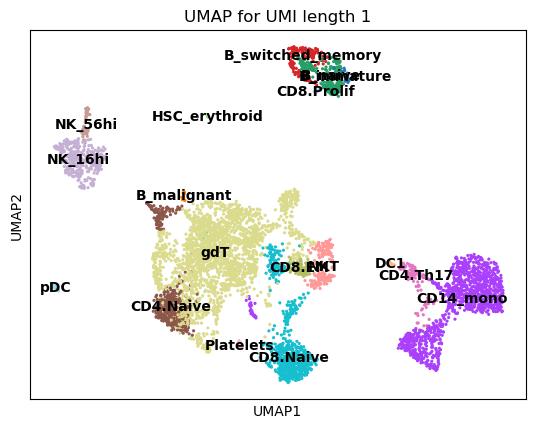

Processing UMI length: 2


🔬 Input data has 5709 cells and 31131 genes
🔗 Matching reference genes in the model
🧬 3430 features used for prediction


Sample of the matrix for UMI length 2:
[[0.        0.        0.        0.        0.       ]
 [0.        0.        0.        0.        0.       ]
 [0.7647091 0.        0.        0.        0.       ]
 [0.        0.        0.        0.        0.       ]
 [0.        0.        0.        0.        0.       ]]
Min: 0.0, Max: 6.666083288249478


⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 10
🗳️ Majority voting the predictions
✅ Majority voting done!


Annotated data saved to: /data/dagyeman/cellranger/bam_file_analysis/5k_PBMCs/ub_objects/adata_matrices/cell_annotations/annotated_adata_matrices/annotated_adata_2.h5ad



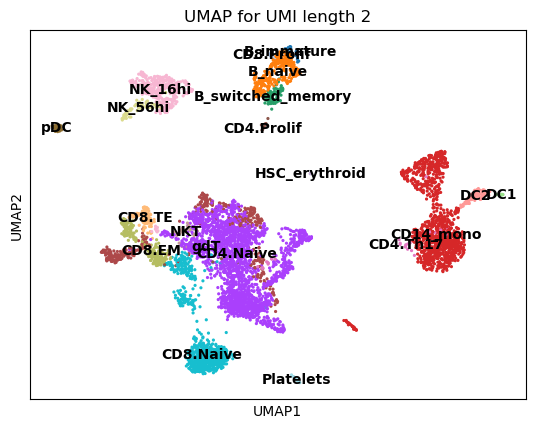

Processing UMI length: 3


🔬 Input data has 5709 cells and 31131 genes
🔗 Matching reference genes in the model
🧬 3430 features used for prediction


Sample of the matrix for UMI length 3:
[[0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.65545137 0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]]
Min: 0.0, Max: 7.277097841543104


⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 10
🗳️ Majority voting the predictions
✅ Majority voting done!


Annotated data saved to: /data/dagyeman/cellranger/bam_file_analysis/5k_PBMCs/ub_objects/adata_matrices/cell_annotations/annotated_adata_matrices/annotated_adata_3.h5ad



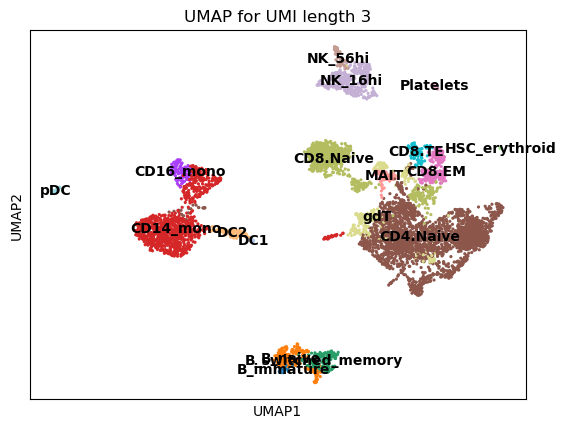

Processing UMI length: 4


🔬 Input data has 5709 cells and 31131 genes
🔗 Matching reference genes in the model


Sample of the matrix for UMI length 4:
[[0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.59939572 0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]]
Min: 0.0, Max: 7.812662716300867


🧬 3430 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 10
🗳️ Majority voting the predictions
✅ Majority voting done!


Annotated data saved to: /data/dagyeman/cellranger/bam_file_analysis/5k_PBMCs/ub_objects/adata_matrices/cell_annotations/annotated_adata_matrices/annotated_adata_4.h5ad



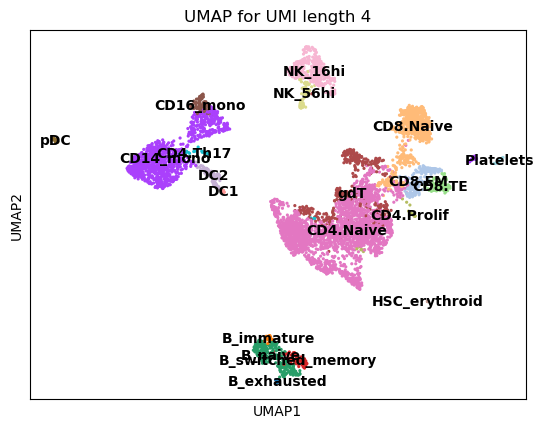

Processing UMI length: 5


🔬 Input data has 5709 cells and 31131 genes
🔗 Matching reference genes in the model


Sample of the matrix for UMI length 5:
[[0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.57041111 0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]]
Min: 0.0, Max: 8.228219319218242


🧬 3430 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 10
🗳️ Majority voting the predictions
✅ Majority voting done!


Annotated data saved to: /data/dagyeman/cellranger/bam_file_analysis/5k_PBMCs/ub_objects/adata_matrices/cell_annotations/annotated_adata_matrices/annotated_adata_5.h5ad



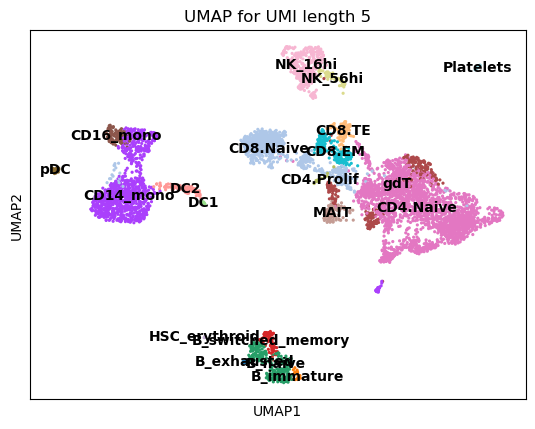

Processing UMI length: 6


🔬 Input data has 5709 cells and 31131 genes
🔗 Matching reference genes in the model


Sample of the matrix for UMI length 6:
[[0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.55959436 0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]]
Min: 0.0, Max: 8.439603422922


🧬 3430 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 10
🗳️ Majority voting the predictions
✅ Majority voting done!


Annotated data saved to: /data/dagyeman/cellranger/bam_file_analysis/5k_PBMCs/ub_objects/adata_matrices/cell_annotations/annotated_adata_matrices/annotated_adata_6.h5ad



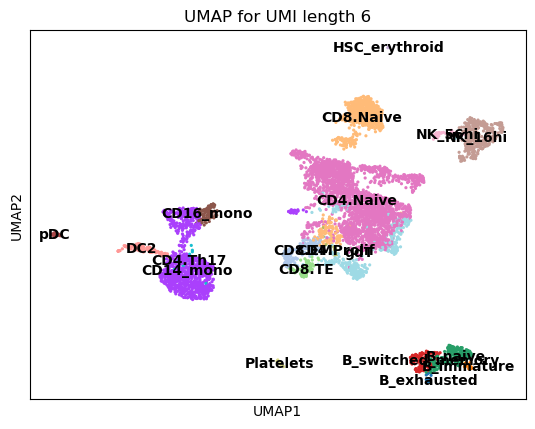

Processing UMI length: 7


🔬 Input data has 5709 cells and 31131 genes
🔗 Matching reference genes in the model


Sample of the matrix for UMI length 7:
[[0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.55589139 0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]]
Min: 0.0, Max: 8.497952668536993


🧬 3430 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 10
🗳️ Majority voting the predictions
✅ Majority voting done!


Annotated data saved to: /data/dagyeman/cellranger/bam_file_analysis/5k_PBMCs/ub_objects/adata_matrices/cell_annotations/annotated_adata_matrices/annotated_adata_7.h5ad



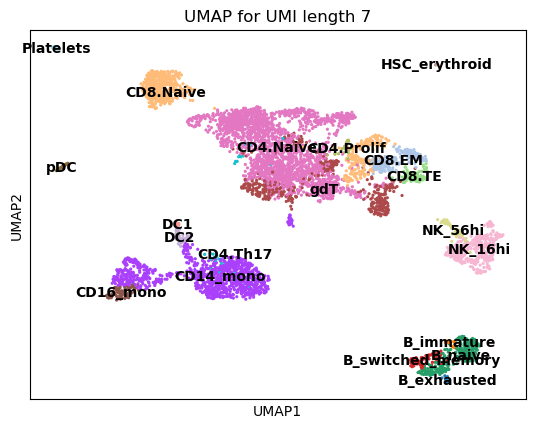

Processing UMI length: 8


🔬 Input data has 5709 cells and 31131 genes
🔗 Matching reference genes in the model


Sample of the matrix for UMI length 8:
[[0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.55478396 0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]]
Min: 0.0, Max: 8.51563450805593


🧬 3430 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 10
🗳️ Majority voting the predictions
✅ Majority voting done!


Annotated data saved to: /data/dagyeman/cellranger/bam_file_analysis/5k_PBMCs/ub_objects/adata_matrices/cell_annotations/annotated_adata_matrices/annotated_adata_8.h5ad



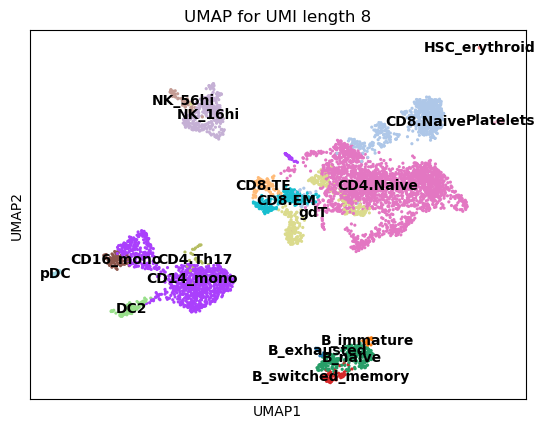

Processing UMI length: 9


🔬 Input data has 5709 cells and 31131 genes
🔗 Matching reference genes in the model


Sample of the matrix for UMI length 9:
[[0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.55449993 0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]]
Min: 0.0, Max: 8.519574713322934


🧬 3430 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 10
🗳️ Majority voting the predictions
✅ Majority voting done!


Annotated data saved to: /data/dagyeman/cellranger/bam_file_analysis/5k_PBMCs/ub_objects/adata_matrices/cell_annotations/annotated_adata_matrices/annotated_adata_9.h5ad



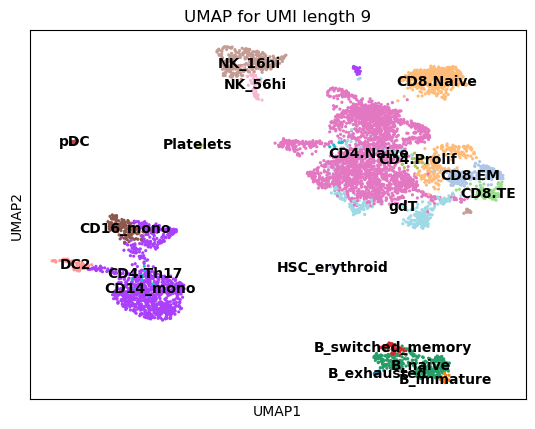

Processing UMI length: 10


🔬 Input data has 5709 cells and 31131 genes
🔗 Matching reference genes in the model


Sample of the matrix for UMI length 10:
[[0.        0.        0.        0.        0.       ]
 [0.        0.        0.        0.        0.       ]
 [0.5542477 0.        0.        0.        0.       ]
 [0.        0.        0.        0.        0.       ]
 [0.        0.        0.        0.        0.       ]]
Min: 0.0, Max: 8.521302889142168


🧬 3430 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 10
🗳️ Majority voting the predictions
✅ Majority voting done!


Annotated data saved to: /data/dagyeman/cellranger/bam_file_analysis/5k_PBMCs/ub_objects/adata_matrices/cell_annotations/annotated_adata_matrices/annotated_adata_10.h5ad



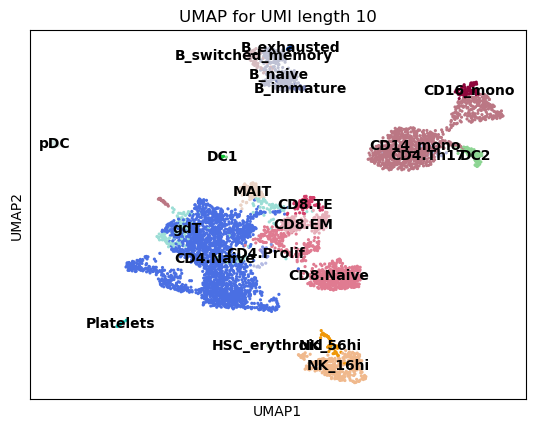

Processing UMI length: 11


🔬 Input data has 5709 cells and 31131 genes
🔗 Matching reference genes in the model


Sample of the matrix for UMI length 11:
[[0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.55409018 0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]]
Min: 0.0, Max: 8.521730707389386


🧬 3430 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 10
🗳️ Majority voting the predictions
✅ Majority voting done!


Annotated data saved to: /data/dagyeman/cellranger/bam_file_analysis/5k_PBMCs/ub_objects/adata_matrices/cell_annotations/annotated_adata_matrices/annotated_adata_11.h5ad



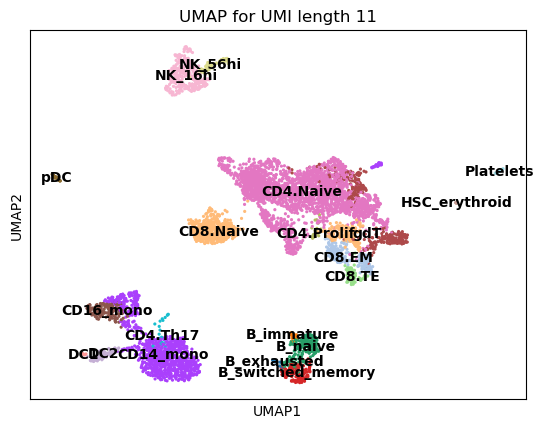

Processing UMI length: 12


🔬 Input data has 5709 cells and 31131 genes
🔗 Matching reference genes in the model


Sample of the matrix for UMI length 12:
[[0.        0.        0.        0.        0.       ]
 [0.        0.        0.        0.        0.       ]
 [0.5540272 0.        0.        0.        0.       ]
 [0.        0.        0.        0.        0.       ]
 [0.        0.        0.        0.        0.       ]]
Min: 0.0, Max: 8.522591452932469


🧬 3430 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 10
🗳️ Majority voting the predictions
✅ Majority voting done!


Annotated data saved to: /data/dagyeman/cellranger/bam_file_analysis/5k_PBMCs/ub_objects/adata_matrices/cell_annotations/annotated_adata_matrices/annotated_adata_12.h5ad



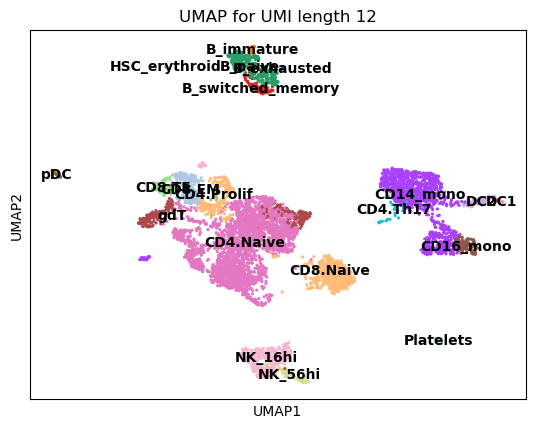

In [ ]:
import scanpy as sc
import celltypist
import os

dataset= "5k_PBMCs"  # Change to "10k_PBMCs" if needed

common_path = f"{base_dir}/{dataset}/ub_objects/adata_matrices"
# common_path = "/data/dagyeman/cellranger/bam_file_analysis/10k_PBMCs/ur_objects/adata_matrices"
filepath = common_path
output_path = os.path.join(common_path, "cell_annotations")

# Load the CellTypist model
model = celltypist.models.Model.load(model='Healthy_COVID19_PBMC.pkl')

# Ensure the output directory exists
os.makedirs(output_path, exist_ok=True)

# Dictionary to store annotated data
annotated_adata_dict = {}

# Process each UMI length
for i in range(1, 13):
    print(f"Processing UMI length: {i}")
    
    # Load the h5ad file for the current UMI length
    adata = sc.read_h5ad(filepath + f"/adata_{i}.h5ad")
    
    # Normalize counts per cell to 10,000
    sc.pp.normalize_total(adata, target_sum=1e4)
    
    # Apply log1p transformation
    sc.pp.log1p(adata)
    
    # Check matrix sample (optional)
    print(f"Sample of the matrix for UMI length {i}:")
    print(adata.X[:5, :5])
    print(f"Min: {adata.X.min()}, Max: {adata.X.max()}")
    
    # Annotate the cell types using the CellTypist model
    predictions = celltypist.annotate(adata, model=model, majority_voting=True)
    
    # Store annotated data
    annotated_adata = predictions.to_adata()
    annotated_adata_dict[i] = annotated_adata
    
    # Save annotated AnnData object
    annotated_output_path = os.path.join(output_path, f"annotated_adata_matrices/annotated_adata_{i}.h5ad")
    annotated_adata.write_h5ad(annotated_output_path)
    print(f"Annotated data saved to: {annotated_output_path}\n")

    # # Compute UMAP
    # sc.tl.umap(annotated_adata)

    # # Plot UMAP with majority voting labels
    # sc.pl.umap(
    #     annotated_adata, 
    #     color=['majority_voting'], 
    #     legend_loc='on data', 
    #     title=f"UMAP for UMI length {i}", 
    #     show=True  # Display instead of saving
    # )